# Weather Mapping Playground

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import meteostat as ms
from datetime import datetime
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
def f_to_c(x):
    return (x - 32)/9*5

In [4]:
def c_to_f(x):
    return x*9/5 + 32


bbox_deg = [-74, -66.5, 40, 48]
res = 0.1
start = datetime(2021, 9, 1)
end = datetime(2024, 9, 1)

lats = np.arange(bbox_deg[2], bbox_deg[3], res)
lons = np.arange(bbox_deg[0], bbox_deg[1], res)
lons_mesh, lats_mesh = np.meshgrid(lons, lats)


data = []
for lat, lon in tqdm(zip(lats_mesh.flatten(), lons_mesh.flatten()), total=len(lats_mesh.flatten())):
    
    point = ms.Point(lat=lat, lon=lon)
    point.alt_range = 2000
    point.radius = 100000
    point.method = 'weighted'
    
    daily_data = ms.Daily(point, start, end)
    daily_data = daily_data.fetch()
    daily_data['lat'] = lat
    daily_data['lon'] = lon
    
    data.append(daily_data)

# Concatenate the data from all locations into a single dataframe
result = pd.concat(data)




# plt.rcParams['date.converter'] = 'auto'


100%|██████████| 6000/6000 [30:06<00:00,  3.32it/s] 


In [5]:
map_data = np.full(lons_mesh.shape, np.nan)
for i, lat in tqdm(enumerate(lats), total=len(lats)):
    for j, lon in enumerate(lons):
        location_data = result[(result['lon'] == lon) & (result['lat'] == lat)]
        data_point = location_data[location_data.index == datetime(2023, 7, 1)]
        if not data_point.empty:
            map_data[i,j] = data_point['tavg']

map_data = c_to_f(map_data)

100%|██████████| 80/80 [00:31<00:00,  2.51it/s]


In [6]:
map_data = np.full(lons_mesh.shape, np.nan)
for i, lat in tqdm(enumerate(lats), total=len(lats)):
    for j, lon in enumerate(lons):
        location_data = result[(result['lon'] == lon) & (result['lat'] == lat)]
        if not location_data.empty:
            map_data[i,j] = np.sum(location_data['tmax'] > f_to_c(90))

100%|██████████| 80/80 [00:30<00:00,  2.59it/s]


Text(0.5, 1.0, 'Average Tempature from 2021-09-01 00:00:00 to 2024-09-01 00:00:00')

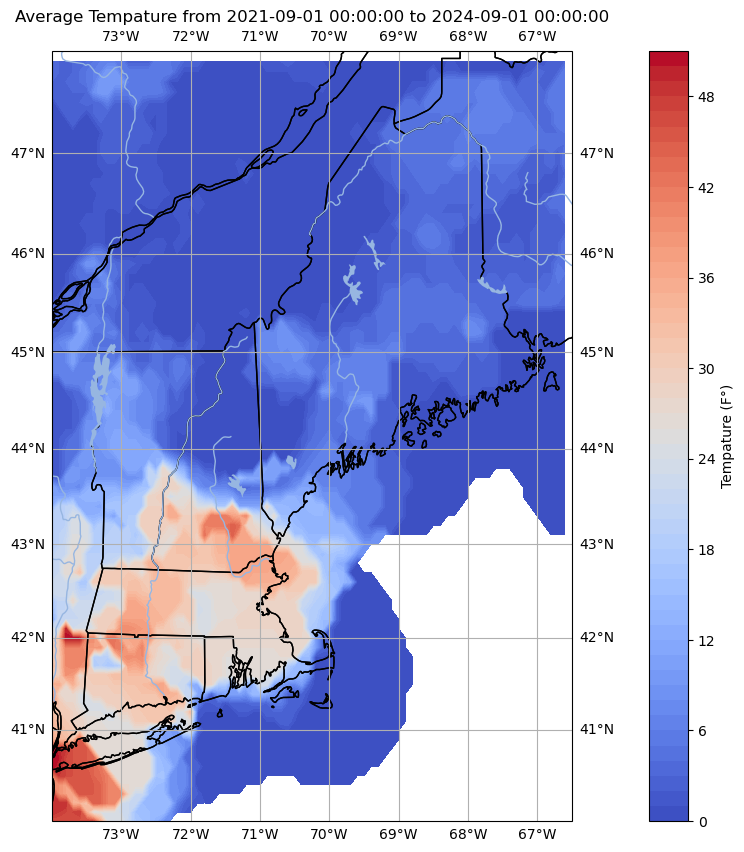

In [11]:


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.set_extent(bbox_deg, ccrs.Geodetic())

ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.coastlines()
ax.gridlines(draw_labels=True)


contour = ax.contourf(lons, lats, map_data, transform=ccrs.PlateCarree(), cmap='coolwarm', levels=50)
fig.colorbar(contour, ax=ax, label="Tempature (F°)")
ax.set_title(f"Average Tempature from {start} to {end}")